## **Install library**

In [1]:
%%capture
!pip install yellowbrick

## **Import libraries**

In [2]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from datetime import timedelta
from mpl_toolkits.mplot3d import Axes3D
from mlxtend.frequent_patterns import apriori, association_rules

## **Load and observe data**

In [20]:
# URL of the CSV file
url = 'https://archive.ics.uci.edu/static/public/352/data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(url)

print(df.info())
print(df.head())

warnings.filterwarnings('ignore', category=DeprecationWarning)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED 

## **Clean and prepare data**

In [21]:
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

## **Purchase trends over time**

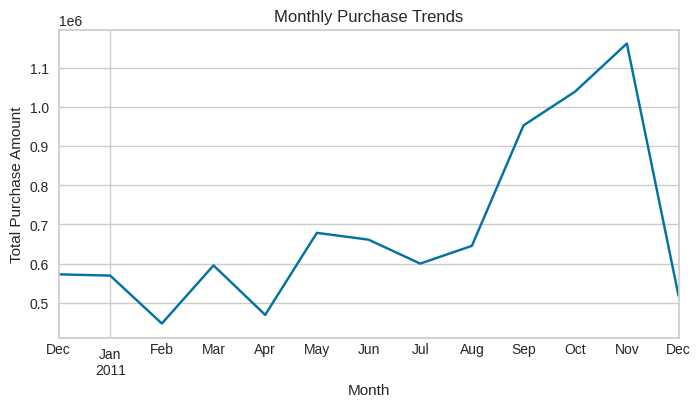

In [22]:
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.to_period('M')
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
monthly_sales = df.groupby('InvoiceYearMonth')['TotalPrice'].sum()

plt.figure(figsize=(8, 4))
monthly_sales.plot(kind='line')
plt.title('Monthly Purchase Trends')
plt.xlabel('Month')
plt.ylabel('Total Purchase Amount')
plt.show()

## **RFM Analysis**

In [6]:
# Recency
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days

# Frequency
frequency_df = df.groupby('CustomerID').size().reset_index(name='Frequency')

# Monetary
monetary_df = df.groupby('CustomerID')['TotalPrice'].sum().reset_index(name='Monetary')

# Merge RFM metrics
rfm_df = df.groupby('CustomerID')['Recency'].min().reset_index()
rfm_df = rfm_df.merge(frequency_df, on='CustomerID')
rfm_df = rfm_df.merge(monetary_df, on='CustomerID')

rfm_df = rfm_df[rfm_df['Monetary'] > 0]

# Print RFM table
print(rfm_df.head(20))

    CustomerID  Recency  Frequency  Monetary
0      12346.0      326          1  77183.60
1      12347.0        2        182   4310.00
2      12348.0       75         31   1797.24
3      12349.0       19         73   1757.55
4      12350.0      310         17    334.40
5      12352.0       36         85   2506.04
6      12353.0      204          4     89.00
7      12354.0      232         58   1079.40
8      12355.0      214         13    459.40
9      12356.0       23         59   2811.43
10     12357.0       33        131   6207.67
11     12358.0        2         19   1168.06
12     12359.0       58        248   6372.58
13     12360.0       52        129   2662.06
14     12361.0      287         10    189.90
15     12362.0        3        266   5226.23
16     12363.0      110         23    552.00
17     12364.0        8         85   1313.10
18     12365.0      291         22    641.38
19     12367.0        4         11    168.90


## **Visualize RFM distribution**

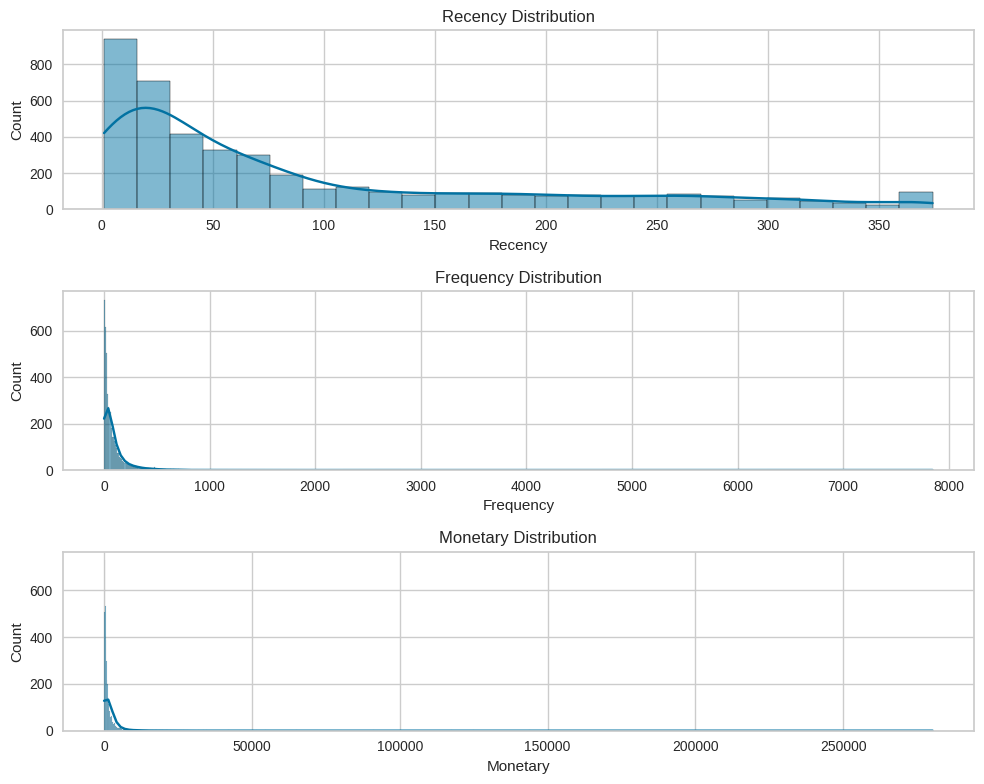

In [7]:
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Recency Distribution')
plt.subplot(3, 1, 2)
sns.histplot(rfm_df['Frequency'], kde=True)
plt.title('Frequency Distribution')
plt.subplot(3, 1, 3)
sns.histplot(rfm_df['Monetary'], kde=True)
plt.title('Monetary Distribution')
plt.tight_layout()
plt.show()

## **Determine the optimal number of clusters using the elbow method**

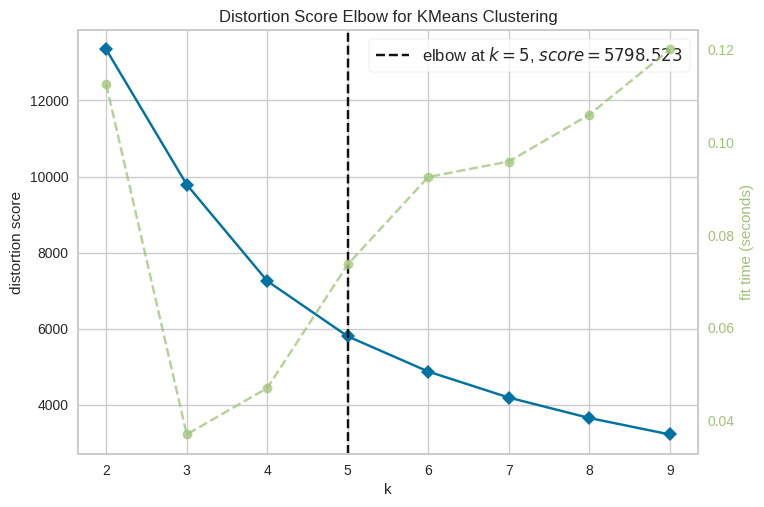

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
# Standardize the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(km, k=(2,10))

# Fit the data to the visualizer
visualizer.fit(rfm_scaled)

# Finalize and render the figure
visualizer.show()

## **Visualize customer segments**

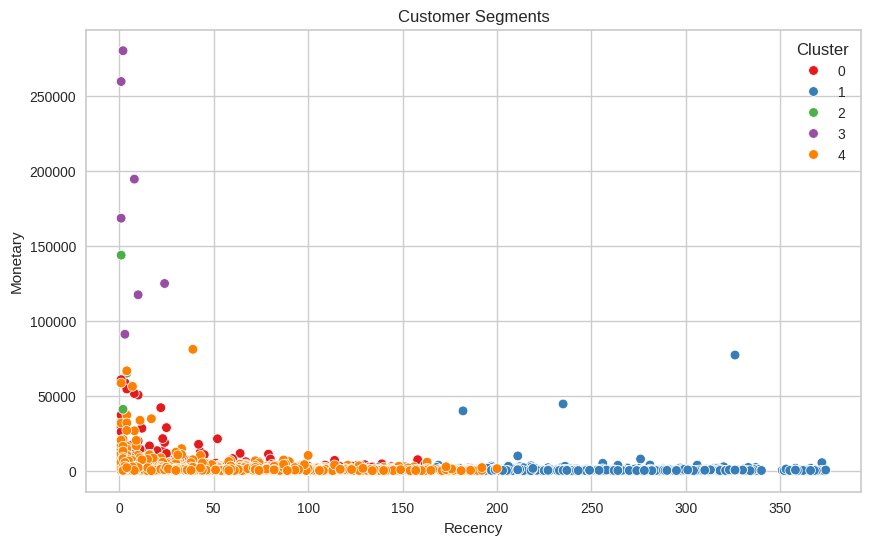

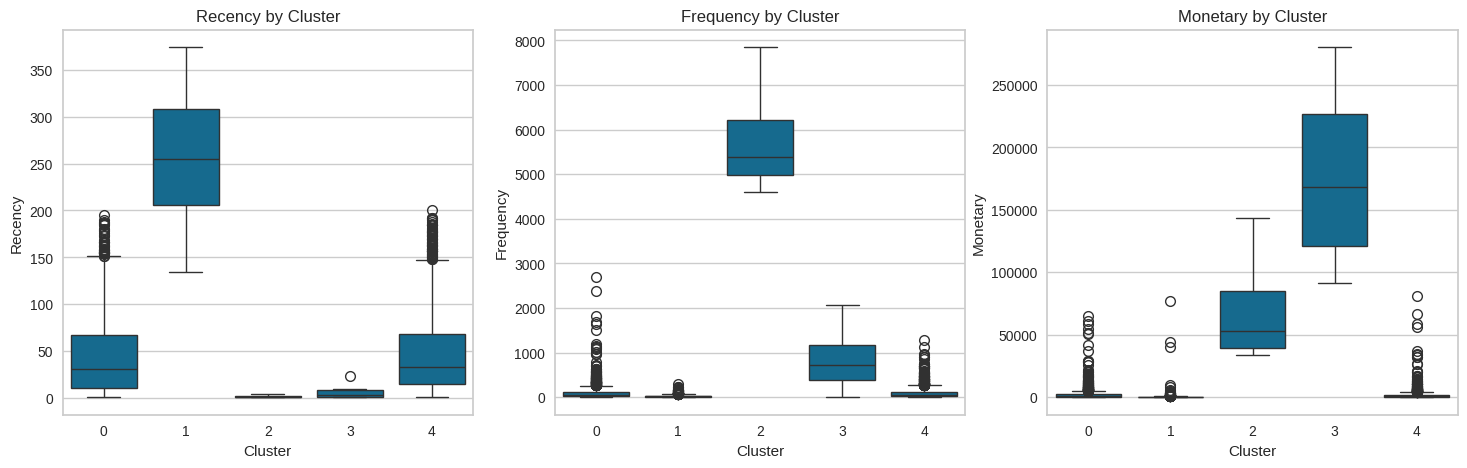

In [9]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster', palette='Set1')
plt.title('Customer Segments')

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm_df)
plt.title('Recency by Cluster')
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm_df)
plt.title('Frequency by Cluster')
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm_df)
plt.title('Monetary by Cluster')
plt.show()

## **3D RFM Clustering**

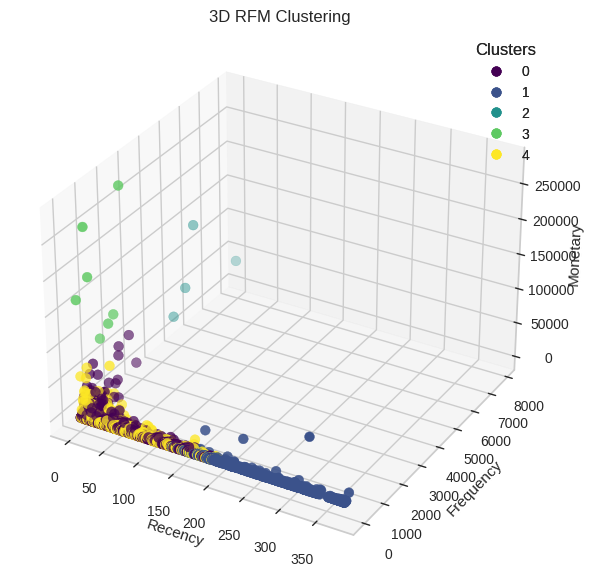

In [10]:
# 3D Scatter Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(rfm_df['Recency'], rfm_df['Frequency'], rfm_df['Monetary'], c=rfm_df['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D RFM Clustering')

# Add legend
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()

## **Sales performance analysis**

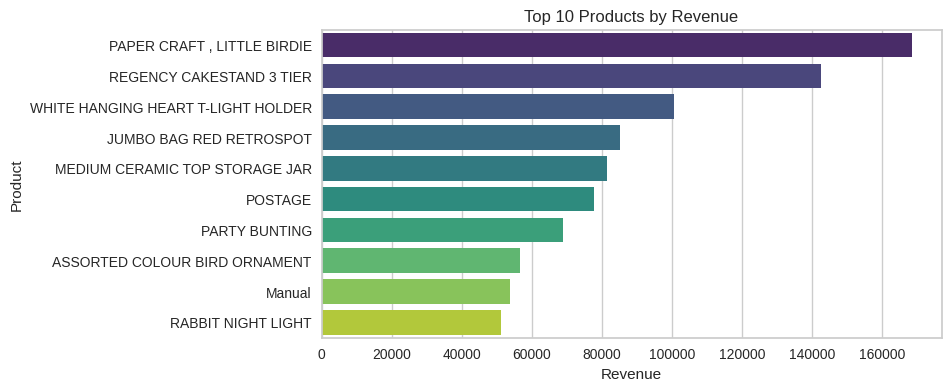

In [23]:
#Top 10 Products by Revenue
top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_products.values, y=top_products.index, hue=top_products.index, palette='viridis', dodge=False, legend=False)
plt.title('Top 10 Products by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Product')
plt.show()

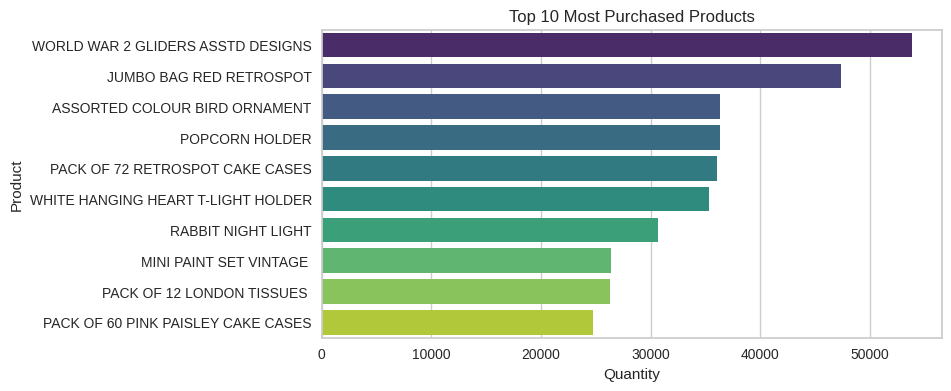

In [17]:
#Top 10 Most Purchased Products
top_purchased_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_purchased_products.values, y=top_purchased_products.index, hue=top_purchased_products.index, palette='viridis', dodge=False, legend=False)
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Quantity')
plt.ylabel('Product')
plt.show()

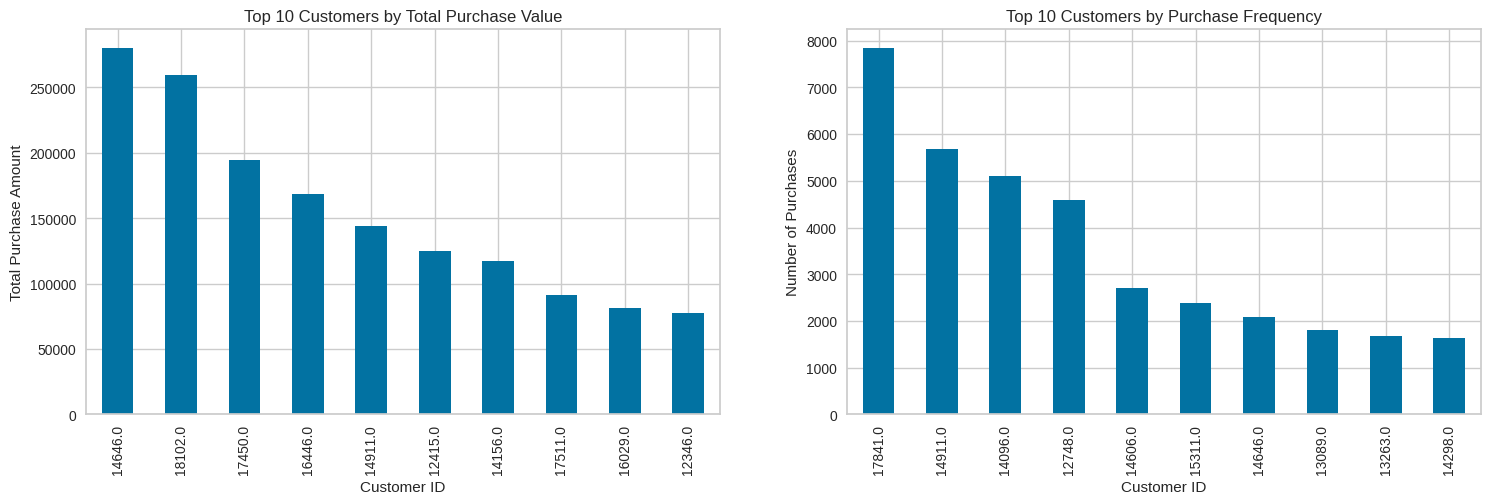

In [13]:
# Top Customers by Total Purchase Value
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_customers.plot(kind='bar')
plt.title('Top 10 Customers by Total Purchase Value')
plt.xlabel('Customer ID')
plt.ylabel('Total Purchase Amount')

# Top 10 Customers by Purchase Frequency
plt.subplot(1, 2, 2)
customer_freq = df['CustomerID'].value_counts()
customer_freq.head(10).plot(kind='bar')
plt.title('Top 10 Customers by Purchase Frequency')
plt.xlabel('Customer ID')
plt.ylabel('Number of Purchases')
plt.show()

## **Churn analysis**

In [14]:
df['Recency'] = (snapshot_date - df['InvoiceDate']).dt.days
churn_rate = df[df['Recency'] > 90].groupby('CustomerID')['InvoiceNo'].count().mean()
print(f'Churn Rate: {churn_rate:.2f}')

Churn Rate: 70.14


## **Market basket analysis**

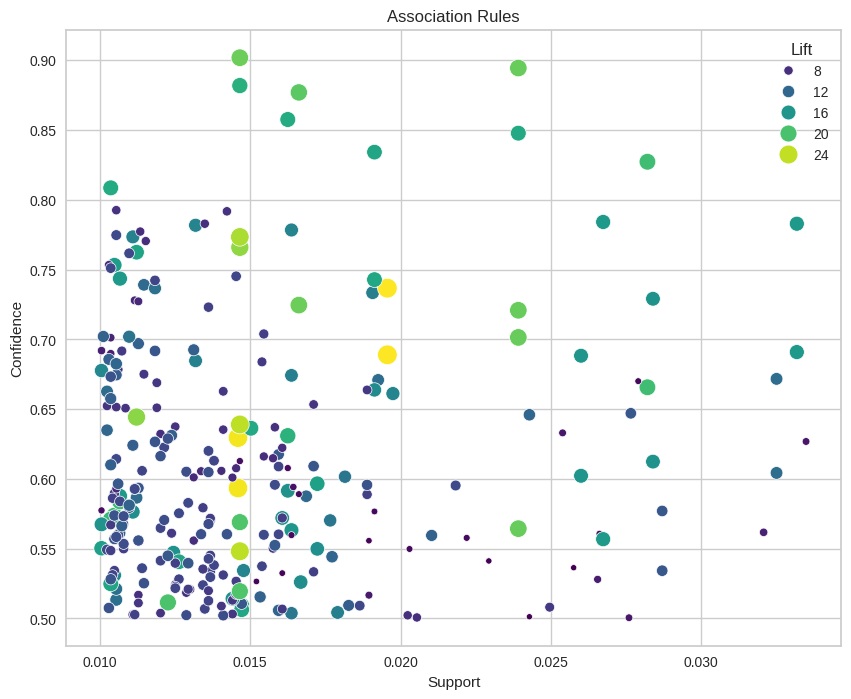

                      antecedents                        consequents  \
15  (60 TEATIME FAIRY CAKE CASES)  (PACK OF 72 RETROSPOT CAKE CASES)   
25   (ALARM CLOCK BAKELIKE IVORY)       (ALARM CLOCK BAKELIKE GREEN)   
27    (ALARM CLOCK BAKELIKE PINK)       (ALARM CLOCK BAKELIKE GREEN)   
28   (ALARM CLOCK BAKELIKE GREEN)        (ALARM CLOCK BAKELIKE RED )   
29    (ALARM CLOCK BAKELIKE RED )       (ALARM CLOCK BAKELIKE GREEN)   
32   (ALARM CLOCK BAKELIKE IVORY)        (ALARM CLOCK BAKELIKE RED )   
34    (ALARM CLOCK BAKELIKE PINK)        (ALARM CLOCK BAKELIKE RED )   
42   (BAKING SET SPACEBOY DESIGN)    (BAKING SET 9 PIECE RETROSPOT )   
47       (BLUE HARMONICA IN BOX )           (RED  HARMONICA IN BOX )   
62  (CHARLOTTE BAG PINK POLKADOT)      (RED RETROSPOT CHARLOTTE BAG)   

     support  confidence       lift  
15  0.020237    0.502283   7.959894  
25  0.016864    0.587607  12.144619  
27  0.021034    0.559543  11.564603  
28  0.032501    0.671736  12.490314  
29  0.032501    0

In [15]:
# Remove cancelled transactions
df = df[~df['InvoiceNo'].str.contains('C', na=False)]

# Reduce the dataset size
# Filter to include only top 200 most frequent items
top_items = df['Description'].value_counts().head(200).index
df = df[df['Description'].isin(top_items)]

# Create a basket matrix with 1 for items purchased and 0 otherwise
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Apply the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate the association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)

# Filter rules with high lift and confidence
rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.5)]

# Visualize the association rules
plt.figure(figsize=(10, 8))
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', data=rules, palette='viridis', sizes=(20, 200))
plt.title('Association Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift')
plt.show()

# Print some of the rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))